In [1]:
import pandas as pd
import numpy as np
from biom import load_table, Table
from scipy.stats import ttest_ind

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import and subset
all_mf = pd.read_csv('../../data/case-studies/uc-severity-multiomics/AGP/10317_20230421-160128.txt', sep='\t', index_col=0, low_memory=False)
mf = pd.read_csv('../../data/case-studies/uc-severity-multiomics/AGP/ibd-redbiom-wgs.txt', sep='\t', index_col=0)
mf_shared = set(['.'.join(x.split('.')[:-1]) for x in mf.index]) & set(all_mf.index)
mf = all_mf.reindex(mf_shared)

mf = mf[~mf.ibd.isin(['diagnosed by a medical professional (doctor, physician assistant)',
                      'diagnosed by an alternative medicine practitioner',
                      'self-diagnosed'])]
mf = mf[~mf['ibs'].isin(['diagnosed by a medical professional (doctor, physician assistant)',
                      'diagnosed by an alternative medicine practitioner',
                      'self-diagnosed'])]

mf = mf[mf.host_body_habitat == 'uberon:feces']
mf = mf[mf.host_age_normalized_years.replace('not applicable',np.nan).replace('Unspecified',np.nan).astype(float) >= 25]
mf = mf[mf.non_food_allergies_unspecified == 'true']

#remove potential duplicates
mf.sort_values(by='collection_timestamp', inplace=True)
mf.reset_index(inplace=True)
mf = mf.groupby('host_subject_id').first()
mf.reset_index(inplace=True)
mf.set_index('sample_name', inplace=True)

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_60994/3574472283.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mf.reset_index(inplace=True)


In [3]:
# add cohort one
cohort_one_table = pd.read_csv('../../data/case-studies/uc-severity-multiomics/Cohort_One/metagenomics_cohort_one.txt', sep='\t', index_col=0)
cohort_one_mf = pd.read_csv('../../data/case-studies/uc-severity-multiomics/Cohort_One/cohort_one_metadata.txt', sep='\t', index_col=0)
shared = list(set(cohort_one_table.columns) & set(cohort_one_mf.index))
cohort_one_table = cohort_one_table[shared]
cohort_one_mf = cohort_one_mf.reindex(shared)

#remove potential duplicates
cohort_one_mf['collection_timestamp'] = pd.to_datetime(cohort_one_mf['COLLECTION_TIMESTAMP'])
cohort_one_mf.sort_values(by='collection_timestamp', inplace=True)
cohort_one_mf.reset_index(inplace=True)
cohort_one_mf = cohort_one_mf.groupby('host_subject_id').first()
cohort_one_mf.reset_index(inplace=True)
cohort_one_mf.set_index('id', inplace=True)

# cohort_one_mf['disease_duration_and_extent_category'] / 'UC'
cohort_one_mf['ibd_add'] = 'UC'
mf['ibd_add'] = 'nonIBD'
mf = pd.concat([mf, cohort_one_mf])

# match to table
bt = load_table('../../data/case-studies/uc-severity-multiomics/AGP/ibd-redbiom-wgs.biom')
bt = bt.filter(bt.ids('sample')[bt.sum('sample') > 500000], axis='sample')
table_df = pd.DataFrame(bt.matrix_data.toarray(), bt.ids('observation'), bt.ids()).T
table_df.index = ['.'.join(x.split('.')[:-1]) for x in table_df.index]
table_df = table_df.groupby(table_df.index).sum().T
table_df = pd.concat([table_df, cohort_one_table], sort=False, axis=1).fillna(0)
bt = Table(table_df.values, table_df.index, table_df.columns)
bt = bt.filter(bt.ids('sample')[bt.sum('sample') > 0], axis='sample')
shared = set(bt.ids()) & set(mf.index)
mf = mf.reindex(shared)
bt = bt.filter(shared)
bt = bt.filter(bt.ids('observation')[bt.sum('observation') > 0], axis='observation')
table_df = pd.DataFrame(bt.matrix_data.toarray(), bt.ids('observation'), bt.ids())
(bt, mf.shape)

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_60994/384834257.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mf['ibd_add'] = 'nonIBD'


(9991 x 863 <class 'biom.table.Table'> with 1771452 nonzero entries (20% dense),
 (863, 796))

In [4]:
# ratios from previous studies
ratio_feats = pd.read_csv('../../data/case-studies/uc-severity-multiomics/Cohort_two/combined-loadings.csv', index_col='wol')
gcf_ranks_tax = pd.read_csv('../../data/case-studies/uc-severity-multiomics/ranks.tsv', sep='\t',index_col=0)
map_gcf = pd.read_csv('../../data/case-studies/uc-severity-multiomics/translate.txt', index_col=0)
map_gcf_dict = map_gcf.gcf.to_dict()
gcf_ranks_tax = gcf_ranks_tax.reindex(map_gcf_dict.keys())
gcf_ranks_tax.index = [map_gcf_dict[x] for x in gcf_ranks_tax.index]
for level_ in ['genus','species']:
    ratio_feats[level_] = [gcf_ranks_tax.loc[x, level_] for x in ratio_feats['Unnamed: 0']]
    
ratio_feats['both'] = ratio_feats[['iHMP','UCSD']].mean(1)
match_ratio = list(set(table_df.index) & set(ratio_feats.index))
table_df_ratio = table_df.copy().reindex(match_ratio)
ratio_feats = ratio_feats.reindex(match_ratio)
# get ratio
n_use = 7
mf_lr = mf.copy()
ratio_feats = ratio_feats.sort_values('both', ascending=True)
num = ratio_feats.index[:n_use].values.ravel()
den = ratio_feats.index[-n_use:].values.ravel()
lr = np.log(table_df_ratio.loc[num, :].fillna(0).sum()) - np.log(table_df_ratio.loc[den, :].fillna(0).sum())
lr[~np.isfinite(lr)] = np.nan
mf_lr['log_ratio'] = lr
mf_lr = mf_lr.dropna(subset=['log_ratio'])
mf_lr['ibd_add'] = [x.replace('nonIBD', 'non-IBD') for x in mf_lr.ibd_add]
(mf_lr.shape[0] / mf.shape[0]) * 100

/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


99.42062572421784

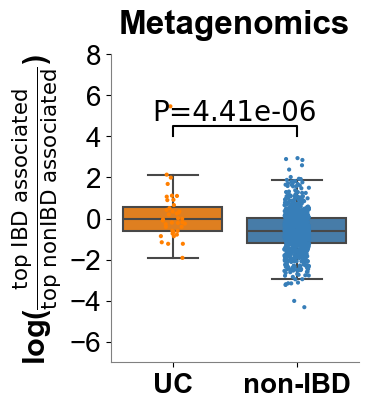

In [9]:
fig, ax = plt.subplots(1,1, figsize=(16/5, 4))

x = mf_lr[mf_lr['ibd_add'] == 'UC']['log_ratio'].values
y = mf_lr[mf_lr['ibd_add'] == 'non-IBD']['log_ratio'].values
t_, p_ = ttest_ind(x, y)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:4] + p_[p_.index('e'):]
else:
    p_ = str(p_)[:6]

stat_ = "P=%s" % (p_)
cmap = {'UC':'#ff7f00', 'non-IBD':'#377eb8'}

sns.stripplot(x='ibd_add', y='log_ratio', order=['UC', 'non-IBD'],  palette=cmap, data=mf_lr, ax=ax, s=3)
sns.boxplot(x='ibd_add', y='log_ratio', order=['UC', 'non-IBD'],  palette=cmap, data=mf_lr, showfliers=False, ax=ax)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(20)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(20)

ax.set_ylim(-7, 8)

ax.set_ylabel('log($\\frac{\\mathrm{top\,\,IBD\,\,associated}}{\\mathrm{top\,\,nonIBD\,\,associated}}$)',
              fontname='Arial', color='black', weight='bold', fontsize=22)
ax.set_xlabel('')

ax.set_title('Metagenomics', fontname='Arial', color='black', weight='bold', fontsize=24, y=1.04)

x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 4, 0.5, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, stat_, ha='center',
        va='bottom', color=col, fontsize=20)

plt.savefig('../../results/figure-4E.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-4E.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()